In [47]:
# 钓鱼的过程可以看成一条马尔可夫链，每一秒像老虎机一样进行一次权重抽奖。权重池里有几种鱼的权重，还有空鱼权重。如果抽到空鱼权重，就再抽一次，直到抽到鱼权重。
# 但是我们可以用CDF的方法来模拟第几次抽到实鱼。
# 某种鱼的权重越高，抽到它的可能性就越大。权重的计算可以看成 基础权重 * 环境系数 * 适配系数，基础权重是配置在鱼场里的。
# 这个版本里，基础权重配置在probWeights表里，忽略环境系数，适配系数简化为鱼对手法的亲和度。
# 有两种算法，一种算法是每次抽奖都是独立的，不受上次抽奖的影响，重复抽。
# 另一种算法是，先算权重池抽到第一次鱼需要多少次的数学期望，再用ICDF转化，表示出次数的波动性，放在空鱼权重里。然后逐步扣减空鱼权重，知道扣减到0，表示抽到鱼。
# 
# 整体的时间逻辑为：
# 1. 初始化时，鱼权重为场次中配置的基础权重，空鱼权重为配置值，计算权重池，以及初始时间
# 2. 间歇性更新权重、更新时间。达到一定时间间隔，或穿越区域/跨越距离的条件下，统计玩家的操作技法，以及饵点的环境数据，更新权重池数据，并更新剩余时间。
# 3. 重复2，直到剩余时间为0/小于0（由于网络jitter、客户端卡顿等原因）则中鱼；
# 每一步中：
# 总权重 = sum（权重池中所有权重值）
# 实鱼权重 = 总权重 - 空鱼权重
# 
# 在路亚钓鱼玩法中，钓鱼的手法对鱼的抽奖权重有影响
# 简单的用手法和鱼对应的系数来计算，不引入状态、技法等概念
# 两条鱼,两种手法，足以展示波动性
# 使用一个xlsx来配置手法和鱼的系数

import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

# 读取配置文件中所有worksheet的数据，返回多个dataframe
dfTrickAff = pd.read_excel('exampleTables/trickFish.xlsx', sheet_name='trickAff')
dfProbWeights = pd.read_excel('exampleTables/trickFish.xlsx', sheet_name='probWeights')
dfTrickSequence = pd.read_excel('exampleTables/trickFish.xlsx', sheet_name='playerTrickSequence')
print(dfTrickAff)
print(dfProbWeights) 
dfTrickSequence

  fishType  trick  aff
0      黄金鲈   抽搐手法  1.5
1     大口黑鲈   抽搐手法  1.0
2      黄金鲈  慢匀收手法  0.5
3     大口黑鲈  慢匀收手法  1.2
4       钓空   抽搐手法  1.0
5       钓空  慢匀收手法  1.0
  fishType  probWeight
0      黄金鲈         500
1     大口黑鲈         100
2       钓空       10000


,step,trick
0,0,慢匀收手法
1,1,慢匀收手法
2,2,慢匀收手法
3,3,慢匀收手法
4,4,慢匀收手法
...,...,...
251,251,慢匀收手法
252,252,抽搐手法
253,253,抽搐手法
254,254,抽搐手法


In [48]:
# 模拟一个玩家的手法变化的过程
trickSeq = dfTrickSequence['trick'].tolist()
print(trickSeq)

['慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '抽搐手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '

In [49]:
dfTrickAff.set_index(['fishType', 'trick'], inplace=True)

# dfTrickAff用前两列作为组合键来查询亲和系数
def getAff(fishType, trick):
    return dfTrickAff.loc[(fishType, trick)]['aff']

# dfProbWeights用第一列作为键来查询权重
dfProbWeights.set_index(['fishType'], inplace=True)
def getProbWeights(fishType):
    return dfProbWeights.loc[fishType]['probWeight']

Total times: 100000
Total fishing time: 1823061
Max fishing time: 181
Min fishing time: 1
Average fishing time: 18.23061


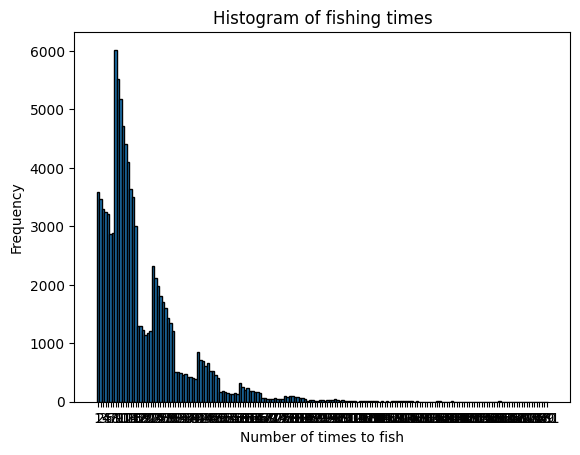

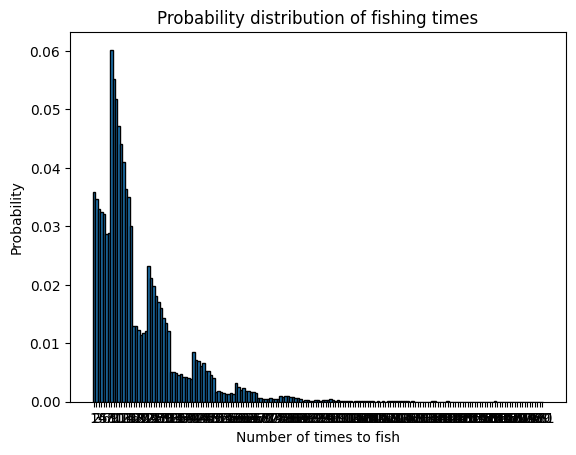

In [50]:
import random
import matplotlib.pyplot as plt

# 预先计算所有鱼种的基准权重
probWeights = {fishType: getProbWeights(fishType) for fishType in dfProbWeights.index}

# 预先计算所有鱼种和手法的亲和度
aff = {fishType: {trick: getAff(fishType, trick) for trick in trickSeq} for fishType in dfProbWeights.index}

# 预先计算每次抽奖的权重列表
weights_per_trick = []
fishTypes = list(dfProbWeights.index)
for trick in trickSeq:
    weights = [probWeights[fishType] * aff[fishType][trick] for fishType in fishTypes]
    weights_per_trick.append(weights)

# 用方法一进行模拟一次
def fishSimulate1Time():
    for idx, weights in enumerate(weights_per_trick, start=1):
        selectedFish = random.choices(fishTypes, weights=weights, k=1)[0]
        if selectedFish != '钓空':
            return idx
    return len(trickSeq)

# 模拟很多次钓鱼，统计抽到鱼的次数，并画图
def fishSimulateNTimes(n):
    fishTimes = [fishSimulate1Time() for _ in range(n)]
    # 打印总次数、总时间、最大时间、最小时间、平均时间
    print('Total times:', n)
    print('Total fishing time:', sum(fishTimes))
    print('Max fishing time:', max(fishTimes))
    print('Min fishing time:', min(fishTimes))
    print('Average fishing time:', np.mean(fishTimes))

    plt.hist(fishTimes, bins=range(1, max(fishTimes) + 2), align='left', edgecolor='black')
    plt.xlabel('Number of times to fish')
    plt.ylabel('Frequency')
    plt.title('Histogram of fishing times')
    plt.xticks(range(1, max(fishTimes) + 1))
    plt.show()
    # 再输出一个概率分布图
    plt.hist(fishTimes, bins=range(1, max(fishTimes) + 2), align='left', edgecolor='black', density=True)
    plt.xlabel('Number of times to fish')
    plt.ylabel('Probability')
    plt.title('Probability distribution of fishing times')
    plt.xticks(range(1, max(fishTimes) + 1))
    plt.show()

fishSimulateNTimes(100000)

In [51]:
totalWeight = dfProbWeights['probWeight'].sum()
realFishWeight = totalWeight - dfProbWeights.loc['钓空']['probWeight']
expectedTimes = totalWeight / realFishWeight
lambda_param = 1 / expectedTimes
print(expectedTimes, lambda_param)

def getICDF(lambda_param):
    return random.expovariate(lambda_param)

# 用ICDF方法模拟一次
def getInitTimes(lambda_param):
    return int(np.ceil(getICDF(lambda_param)))

def initEmptyFishWeight():
    initTimes = getICDF(lambda_param)
    initEmptyFishWeight = realFishWeight * initTimes
    # print('initiating empty fish weight, initTimes:', initTimes)
    return initEmptyFishWeight

    

17.666666666666668 0.056603773584905655


In [52]:
weights_per_trick[0]

[250.0, 120.0, 10000.0]

总次数: 100000
总时间: 1869047
平均时间: 18.69047


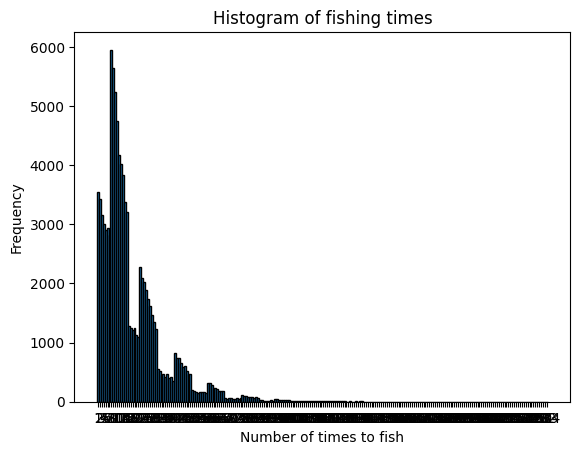

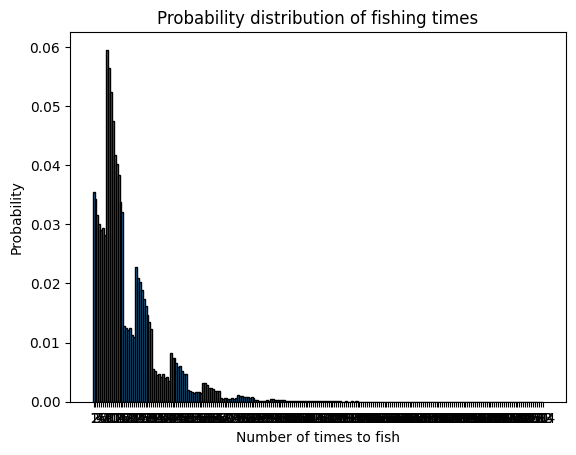

In [53]:
deltaTime = 1

# 用ICDF方法模拟一次
def fishSimulate1TimeICDF(log=False):
    # 初始化空鱼权重
    emptyFishWeight = initEmptyFishWeight()
    for idx, trick in enumerate(weights_per_trick, start=0):
        # 用手法带来的实鱼权重*deltaTime，扣减空鱼权重，直到小于等于0，则中鱼了
        fishWeights = weights_per_trick[idx]
        curRealFishWeight = sum(fishWeights[:2])
        emptyFishWeight -= curRealFishWeight * deltaTime
        if log:
            print('fishWeights:', fishWeights)
            print('curRealFishWeight:', curRealFishWeight)
            print('emptyFishWeight:', emptyFishWeight)
        if emptyFishWeight <= 0:
            if log:
                print(f'第{idx + 1}次抽中了鱼')
            return idx + 1
        
# 模拟很多次钓鱼，统计抽到鱼的次数，并画图
def fishSimulateNTimesICDF(n):
    fishTimes = [fishSimulate1TimeICDF() for _ in range(n)]
    # 打印总次数、总时间、平均时间
    print('总次数:', n)
    print('总时间:', sum(fishTimes))
    print('平均时间:', sum(fishTimes) / n)

    plt.hist(fishTimes, bins=range(1, max(fishTimes) + 2), align='left', edgecolor='black')
    plt.xlabel('Number of times to fish')
    plt.ylabel('Frequency')
    plt.title('Histogram of fishing times')
    plt.xticks(range(1, max(fishTimes) + 1))
    plt.show()
    # 再输出一个概率分布图
    plt.hist(fishTimes, bins=range(1, max(fishTimes) + 2), align='left', edgecolor='black', density=True)
    plt.xlabel('Number of times to fish')
    plt.ylabel('Probability')
    plt.title('Probability distribution of fishing times')
    plt.xticks(range(1, max(fishTimes) + 1))
    plt.show()

fishSimulateNTimesICDF(100000)

In [54]:
# 定义每次路亚收线的时间为一个区间内的随机数
def getReelingTime():
    return random.randint(8, 15)

总共模拟时间：927740 秒
平均每次钓到鱼所用时间：7.02 秒
平均每次钓到鱼所用手法次数：7.02 次
平均两次钓到鱼之间的时间：20.81 秒
平均两次钓到鱼之间的手法次数：20.81 次


c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38035 (\N{CJK UNIFIED IDEOGRAPH-9493}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21040 (\N{CJK UNIFIED IDEOGRAPH-5230}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40060 (\N{CJK UNIFIED IDEOGRAPH-9C7

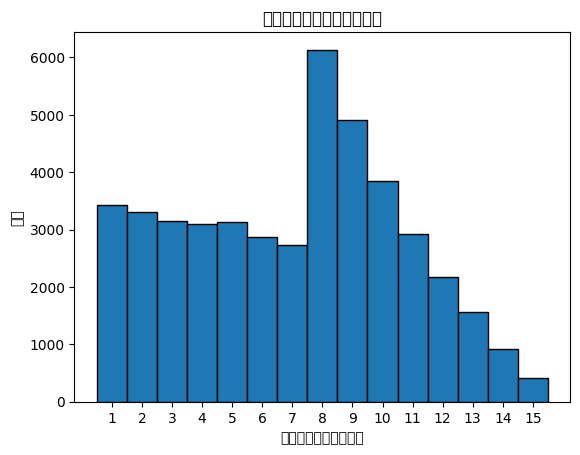

c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20004 (\N{CJK UNIFIED IDEOGRAPH-4E24}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20043 (\N{CJK UNIFIED IDEOGRAPH-4E4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


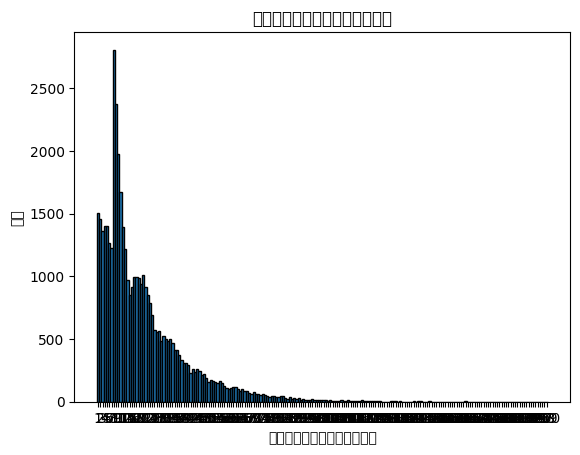

In [55]:
deltaTime = 1

# 用 ICDF 方法模拟一次钓鱼
def fishSimulate1TimeICDFWithLifts(maxTime):
    # 初始化空鱼权重
    emptyFishWeight = initEmptyFishWeight()
    # 累计经过的时间
    elapsedTime = 0
    trickCount = 0
    idx = 0
    while elapsedTime < maxTime:
        # 获取当前手法的权重，这里假设 weights_per_trick 已经预先计算好
        fishWeights = weights_per_trick[idx % len(weights_per_trick)]
        # 计算当前手法带来的实鱼权重
        curRealFishWeight = sum(fishWeights[:2])  # 假设前两个鱼种是目标鱼
        # 扣减空鱼权重
        emptyFishWeight -= curRealFishWeight * deltaTime
        # 增加经过的时间和手法计数
        elapsedTime += deltaTime
        trickCount += 1
        idx += 1
        # 判断是否钓到鱼
        if emptyFishWeight <= 0:
            # 返回钓到鱼的标志和所用时间
            return True, elapsedTime, trickCount
    # 如果在抬竿时间内未钓到鱼，返回未钓到鱼的标志和抬竿时间
    return False, maxTime, trickCount

# 模拟多次钓鱼，统计每次钓到鱼的时间，并绘制直方图
def fishSimulateNTimesICDFWithLifts(n):
    totalTime = 0
    timesBetweenCatches = []
    timesToCatch = []
    tricksBetweenCatches = []
    tricksToCatch = []
    timeSinceLastCatch = 0
    tricksSinceLastCatch = 0

    for _ in range(n):
        # 每次抛竿，让抬竿时间在 8 到 15 秒之间随机
        maxTime = getReelingTime()
        # 模拟一次钓鱼
        caughtFish, timeUsed, tricksUsed = fishSimulate1TimeICDFWithLifts(maxTime)
        # 更新总时间和自上次钓到鱼的累计时间
        totalTime += timeUsed
        timeSinceLastCatch += timeUsed
        tricksSinceLastCatch += tricksUsed
        if caughtFish:
            # 记录钓到鱼所用的时间和手法次数
            timesToCatch.append(timeUsed)
            tricksToCatch.append(tricksUsed)
            # 记录两次钓到鱼之间的时间和手法次数
            timesBetweenCatches.append(timeSinceLastCatch)
            tricksBetweenCatches.append(tricksSinceLastCatch)
            # 重置自上次钓到鱼的累计时间和手法次数
            timeSinceLastCatch = 0
            tricksSinceLastCatch = 0

    # 输出统计信息
    print(f"总共模拟时间：{totalTime} 秒")
    print(f"平均每次钓到鱼所用时间：{sum(timesToCatch)/len(timesToCatch):.2f} 秒")
    print(f"平均每次钓到鱼所用手法次数：{sum(tricksToCatch)/len(tricksToCatch):.2f} 次")
    print(f"平均两次钓到鱼之间的时间：{sum(timesBetweenCatches)/len(timesBetweenCatches):.2f} 秒")
    print(f"平均两次钓到鱼之间的手法次数：{sum(tricksBetweenCatches)/len(tricksBetweenCatches):.2f} 次")

    # 绘制钓到鱼所用时间的分布直方图
    plt.hist(timesToCatch, bins=range(int(min(timesToCatch)), int(max(timesToCatch)) + 2), align='left', edgecolor='black')
    plt.xlabel('钓到鱼所用时间（秒）')
    plt.ylabel('频率')
    plt.title('钓到鱼所用时间分布直方图')
    plt.xticks(range(int(min(timesToCatch)), int(max(timesToCatch)) + 1))
    plt.show()

    # 绘制两次钓到鱼之间时间的分布直方图
    plt.hist(timesBetweenCatches, bins=range(int(min(timesBetweenCatches)), int(max(timesBetweenCatches)) + 2), align='left', edgecolor='black')
    plt.xlabel('两次钓到鱼之间的时间（秒）')
    plt.ylabel('频率')
    plt.title('两次钓到鱼之间时间分布直方图')
    plt.xticks(range(int(min(timesBetweenCatches)), int(max(timesBetweenCatches)) + 1))
    plt.show()

# 运行模拟
fishSimulateNTimesICDFWithLifts(100000)

In [56]:
from scipy.special import erfinv
from scipy.stats import truncnorm

# 现在将ICDF修改为截断的正态分布ICDF，重新进行模拟
def truncated_normal_icdf(mu, sigma, a, b, size=1):
    """
    使用逆累积分布函数法生成截断正态分布随机数

    参数:
    - mu: 正态分布的均值
    - sigma: 正态分布的标准差
    - a: 截断区间的下界
    - b: 截断区间的上界
    - size: 生成随机数的数量

    返回:
    - samples: 服从截断正态分布的随机数数组
    """
    # 计算截断正态分布的标准化上下界
    a, b = (a - mu) / sigma, (b - mu) / sigma
    # 生成截断正态分布的随机数
    samples = truncnorm.rvs(a, b, loc=mu, scale=sigma, size=size)
    return samples

def getICDF(lambda_param=1/15)->float:
    timeExpect = 1/lambda_param
    return truncated_normal_icdf(timeExpect, timeExpect,0, 2.5 * timeExpect, 1).item()


总次数: 100000
总时间: 2087157
平均时间: 20.87157


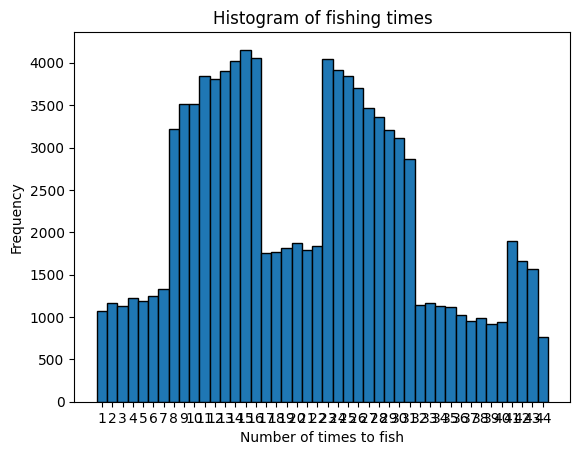

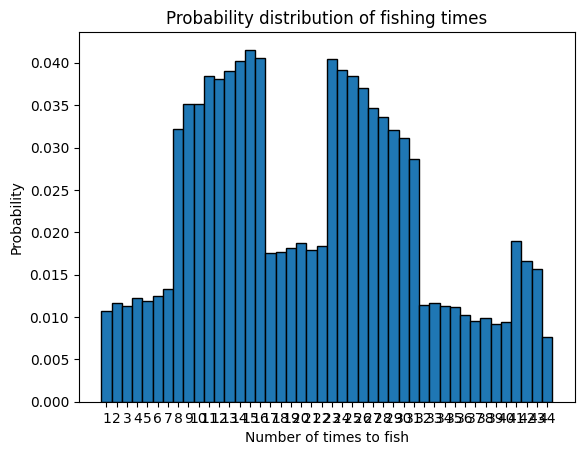

In [57]:
# 不收竿再抛，每次钓到中鱼为止，统计中鱼时间的分布
# 用 ICDF 方法模拟;下面看收竿后如果重置空鱼权重，结果是否能跟每次钓到中鱼不收竿的结果一致
fishSimulateNTimesICDF(100000)

总共模拟时间：1051964 秒
平均每次钓到鱼所用时间：8.31 秒
平均每次钓到鱼所用手法次数：8.31 次
平均两次钓到鱼之间的时间：42.72 秒
平均两次钓到鱼之间的手法次数：42.72 次


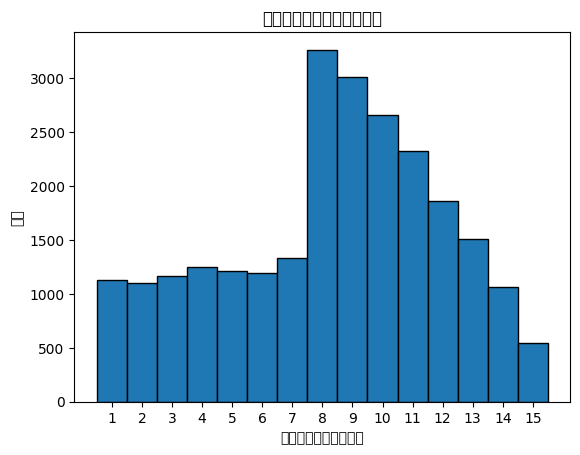

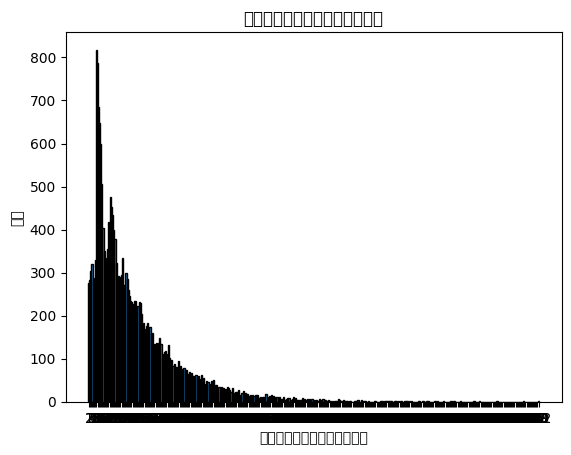

In [60]:
# 如果抬放竿，但是不延续上一次的空鱼权重，重新开始计时，会使得中鱼时间比期望时间变长；也就是说，如果分多次拉路亚，需要更长的时间才能拉回来。
# （单次时间变短，是因为有很多次抛竿得不到鱼的情况会被裁切掉；到了15秒之内，玩家就抬竿了，所以均值不可能大于15）
fishSimulateNTimesICDFWithLifts(100000)

总共模拟时间：907178 秒
平均每次钓到鱼所用时间：6.35 秒
平均每次钓到鱼所用手法次数：6.35 次
平均两次钓到鱼之间的时间：20.93 秒
平均两次钓到鱼之间的手法次数：20.93 次


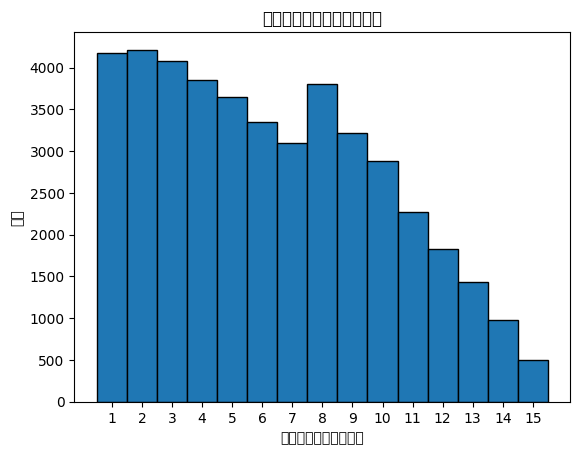

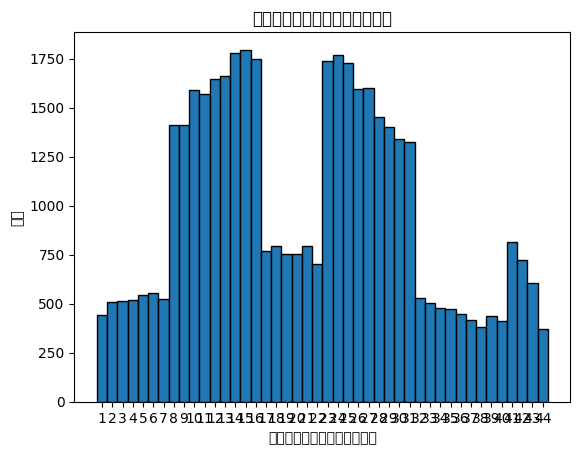

In [59]:
deltaTime = 1

# 用 ICDF 方法模拟一次钓鱼（带连续空鱼权重）
def fishSimulate1TimeICDFWithLifts_Continuous(maxTime, emptyFishWeight, startIdx):
    # 累计经过的时间
    elapsedTime = 0
    trickCount = 0
    idx = startIdx
    while elapsedTime < maxTime:
        # 获取当前手法的权重，这里假设 weights_per_trick 已经预先计算好
        fishWeights = weights_per_trick[idx % len(weights_per_trick)]
        # 计算当前手法带来的实鱼权重
        curRealFishWeight = sum(fishWeights[:2])  # 假设前两个鱼种是目标鱼
        # 扣减空鱼权重
        emptyFishWeight -= curRealFishWeight * deltaTime
        # 增加经过的时间和手法计数
        elapsedTime += deltaTime
        trickCount += 1
        idx += 1
        # 判断是否钓到鱼
        if emptyFishWeight <= 0:
            # 钓到鱼，返回结果并重置空鱼权重
            return True, elapsedTime, trickCount, emptyFishWeight, idx
    # 未钓到鱼，返回结果和当前空鱼权重
    return False, elapsedTime, trickCount, emptyFishWeight, idx

# 模拟多次钓鱼，统计每次钓到鱼的时间，并绘制直方图
def fishSimulateNTimesICDFWithLifts_Continuous(n):
    totalTime = 0
    timesBetweenCatches = []
    timesToCatch = []
    tricksBetweenCatches = []
    tricksToCatch = []
    timeSinceLastCatch = 0
    tricksSinceLastCatch = 0
    emptyFishWeight = initEmptyFishWeight()  # 初始化空鱼权重
    trickIdx = 0  # 初始化手法索引

    for _ in range(n):
        # 每次抛竿，让抬竿时间在 8 到 (15) 秒之间随机 15秒可能调整
        maxTime = getReelingTime()
        # 模拟一次钓鱼
        caughtFish, timeUsed, tricksUsed, emptyFishWeight, trickIdx = fishSimulate1TimeICDFWithLifts_Continuous(maxTime, emptyFishWeight, trickIdx)
        # 更新总时间和自上次钓到鱼的累计时间
        totalTime += timeUsed
        timeSinceLastCatch += timeUsed
        tricksSinceLastCatch += tricksUsed
        if caughtFish:
            # 记录钓到鱼所用的时间和手法次数
            timesToCatch.append(timeUsed)
            tricksToCatch.append(tricksUsed)
            # 记录两次钓到鱼之间的时间和手法次数
            timesBetweenCatches.append(timeSinceLastCatch)
            tricksBetweenCatches.append(tricksSinceLastCatch)
            # 重置自上次钓到鱼的累计时间和手法次数
            timeSinceLastCatch = 0
            tricksSinceLastCatch = 0
            emptyFishWeight = initEmptyFishWeight()  # 重置空鱼权重
            trickIdx = 0  # 重置手法索引

    # 输出统计信息
    print(f"总共模拟时间：{totalTime} 秒")
    print(f"平均每次钓到鱼所用时间：{sum(timesToCatch)/len(timesToCatch):.2f} 秒")
    print(f"平均每次钓到鱼所用手法次数：{sum(tricksToCatch)/len(tricksToCatch):.2f} 次")
    print(f"平均两次钓到鱼之间的时间：{sum(timesBetweenCatches)/len(timesBetweenCatches):.2f} 秒")
    print(f"平均两次钓到鱼之间的手法次数：{sum(tricksBetweenCatches)/len(tricksBetweenCatches):.2f} 次")

    # 绘制钓到鱼所用时间的分布直方图
    plt.hist(timesToCatch, bins=range(int(min(timesToCatch)), int(max(timesToCatch)) + 2), align='left', edgecolor='black')
    plt.xlabel('钓到鱼所用时间（秒）')
    plt.ylabel('频率')
    plt.title('钓到鱼所用时间分布直方图')
    plt.xticks(range(int(min(timesToCatch)), int(max(timesToCatch)) + 1))
    plt.show()

    # 绘制两次钓到鱼之间时间的分布直方图
    plt.hist(timesBetweenCatches, bins=range(int(min(timesBetweenCatches)), int(max(timesBetweenCatches)) + 2), align='left', edgecolor='black')
    plt.xlabel('两次钓到鱼之间的时间（秒）')
    plt.ylabel('频率')
    plt.title('两次钓到鱼之间时间分布直方图')
    plt.xticks(range(int(min(timesBetweenCatches)), int(max(timesBetweenCatches)) + 1))
    plt.show()

# 运行模拟
fishSimulateNTimesICDFWithLifts_Continuous(100000)

In [96]:
getICDF()

27.024041388392362

In [169]:
import numpy as np
import random

# 定义初始参数
realFishWeight = 600
emptyFishWeight = 10000
a = 2  # 假设最大时间倍率 a 为 2

# 第一步：计算 λ
totalWeight = realFishWeight + emptyFishWeight
lambda_param = realFishWeight / totalWeight
print(f"Step 1: λ = {lambda_param}")

# 第二步：生成均匀随机数 U
U = random.uniform(0, 1)
print(f"Step 2: U = {U}")

# 第三步：计算 1 - e^(-a * λ)
exp_term = np.exp(-a * lambda_param)
one_minus_exp_term = 1 - exp_term
print(f"Step 3: 1 - e^(-a * λ) = {one_minus_exp_term}")

# 第四步：计算 1 - U * (1 - e^(-a * λ))
one_minus_U_exp_term = 1 - U * one_minus_exp_term
print(f"Step 4: 1 - U * (1 - e^(-a * λ)) = {one_minus_U_exp_term}")

# 第五步：计算 ln(1 - U * (1 - e^(-a * λ)))
ln_term = np.log(one_minus_U_exp_term)
print(f"Step 5: ln(1 - U * (1 - e^(-a * λ))) = {ln_term}")

# 第六步：计算 x = -1/λ * ln(1 - U * (1 - e^(-a * λ)))
x = -1 / lambda_param * ln_term
print(f"Step 6: x = {x}")

# 第七步：更新空鱼权重
updated_emptyFishWeight = realFishWeight * x
print(f"Step 7: 更新后的空鱼权重 = {updated_emptyFishWeight}")

Step 1: λ = 0.05660377358490566
Step 2: U = 0.954485774481241
Step 3: 1 - e^(-a * λ) = 0.10703469154043543
Step 4: 1 - U * (1 - e^(-a * λ)) = 0.8978369095486668
Step 5: ln(1 - U * (1 - e^(-a * λ))) = -0.10776684237590538
Step 6: x = 1.9038808819743285
Step 7: 更新后的空鱼权重 = 1142.328529184597


c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31354 (\N{CJK UNIFIED IDEOGRAPH-7A7A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40060 (\N{CJK UNIFIED IDEOGRAPH-9C7C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26435 (\N{CJK UNIFIED IDEOGRAPH-674

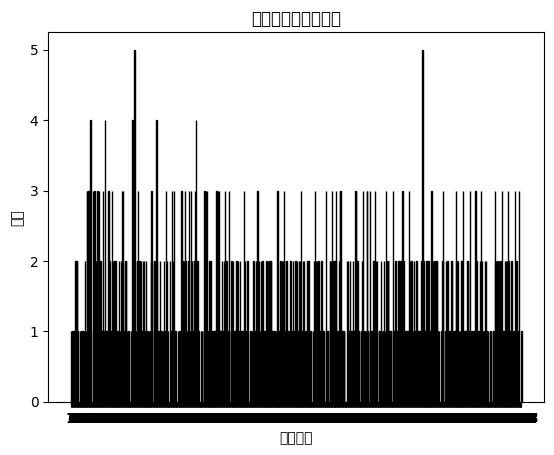

In [170]:
# 做1000这样的计算，看看空鱼权重的分布
emptyFishWeights = []
for _ in range(1000):
    U = random.uniform(0, 1)
    one_minus_U_exp_term = 1 - U * one_minus_exp_term
    ln_term = np.log(one_minus_U_exp_term)
    x = -1 / lambda_param * ln_term
    updated_emptyFishWeight = realFishWeight * x
    emptyFishWeights.append(updated_emptyFishWeight)

# 绘制空鱼权重的分布直方图
plt.hist(emptyFishWeights, bins=range(int(min(emptyFishWeights)), int(max(emptyFishWeights)) + 2), align='left', edgecolor='black')
plt.xlabel('空鱼权重')
plt.ylabel('频率')
plt.title('空鱼权重分布直方图')
plt.xticks(range(int(min(emptyFishWeights)), int(max(emptyFishWeights)) + 1))
plt.show()

生成的随机数 x = 11.035037050747707


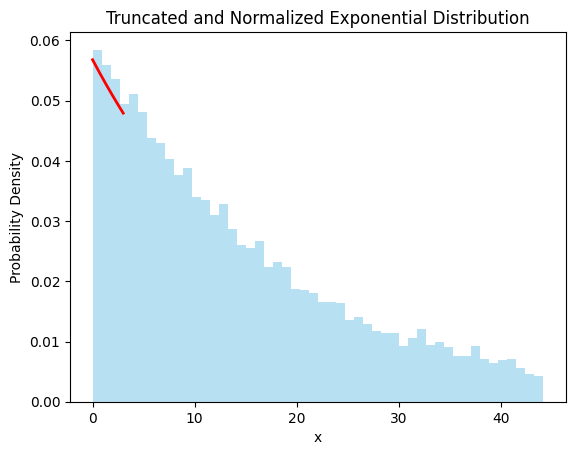

In [200]:
import numpy as np

def generate_truncated_exponential(lambda_param):
    U = np.random.uniform(0, 1)
    x = - (1 / lambda_param) * np.log(1 - U * (1 - np.exp(-2.5)))
    return x

# 设定 λ 参数
lambda_param = 600/10600  # 您可以根据需要调整 λ 的值
# lambda_param = 1

# 生成一个随机样本
sample = generate_truncated_exponential(lambda_param)
print(f"生成的随机数 x = {sample}")

# 生成多个样本并绘制直方图
import matplotlib.pyplot as plt

samples = [generate_truncated_exponential(lambda_param) for _ in range(10000)]
plt.hist(samples, bins=50, density=True, alpha=0.6, color='skyblue')

# 绘制理论概率密度函数
x_values = np.linspace(0, 3, 10000)
pdf_values = (lambda_param * np.exp(-lambda_param * x_values)) / (1 - np.exp(-100 * lambda_param))
plt.plot(x_values, pdf_values, 'r-', lw=2)

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Truncated and Normalized Exponential Distribution')
plt.show()


In [205]:
# 求sample的均值
print(10600/600)
np.mean(samples)

17.666666666666668


13.751332936595764

# s calculation and ICDF calculation

In [225]:
import numpy as np

def generate_adjusted_exponential(lambda_param, a):
    # 计算 e^{-a}
    exp_neg_a = np.exp(-a)
    
    # 计算缩放因子 s
    numerator = 1 - exp_neg_a
    denominator = 1 - exp_neg_a * (a + 1)
    s = np.sqrt(numerator / denominator)
    
    # 生成均匀随机数 U
    U = np.random.uniform(0, 1)
    
    # 计算 x
    x = - (s / lambda_param) * np.log(1 - U * (1 - exp_neg_a))
    return x

# 参数设定
lambda_param = 600/10600  # 根据您的情况
a = 2.5  # 截断参数

# 生成一个随机样本
sample = generate_adjusted_exponential(lambda_param, a)
print(f"生成的随机时间 x = {sample:.2f} 秒")

生成的随机时间 x = 16.88 秒


In [226]:
# 提前计算，当a=2.5时，s的值
exp_neg_a = np.exp(-2.5)

numerator = 1 - exp_neg_a
denominator = 1 - exp_neg_a * (2.5 + 1)
s = np.sqrt(numerator / denominator)
s

1.13487254911167

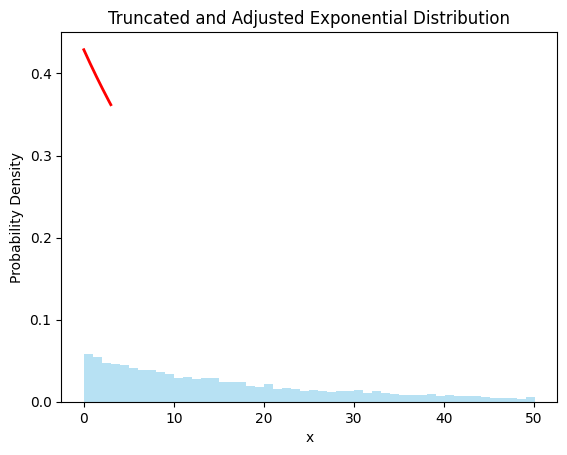

理论均值：17.67 秒


15.361688462386843

In [227]:
# 生成10000个样本并绘制直方图，且计算均值
samples = [generate_adjusted_exponential(lambda_param, a) for _ in range(10000)]
plt.hist(samples, bins=50, density=True, alpha=0.6, color='skyblue')

# 绘制理论概率密度函数
x_values = np.linspace(0, 3, 10000)
pdf_values = (lambda_param * np.exp(-lambda_param * x_values)) / (1 - np.exp(-a * lambda_param))
plt.plot(x_values, pdf_values, 'r-', lw=2)

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Truncated and Adjusted Exponential Distribution')
plt.show()

print(f"理论均值：{1/lambda_param:.2f} 秒")

# 求sample的均值
np.mean(samples)


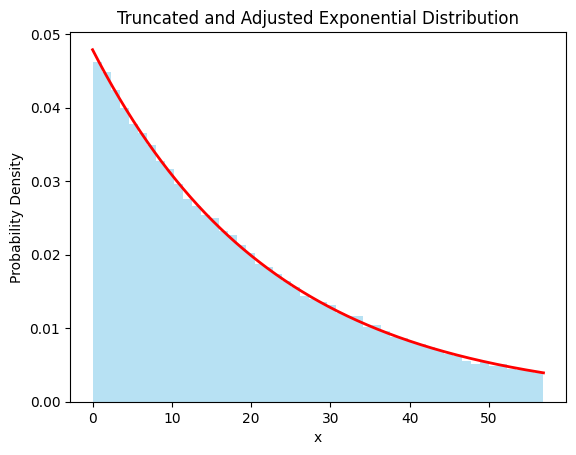

理论均值：17.67 秒
采样平均值：17.63 秒


In [232]:
# 修改s的计算，之前多了一个平方根

import numpy as np
import matplotlib.pyplot as plt

def generate_adjusted_exponential(lambda_param, a):
    # 计算 e^{-a}
    exp_neg_a = np.exp(-a)
    
    # 计算缩放因子 s
    numerator = 1 - exp_neg_a
    denominator = 1 - exp_neg_a * (a + 1)
    s = numerator / denominator  # 去掉平方根
    
    # 生成均匀随机数 U
    U = np.random.uniform(0, 1)
    
    # 计算 x
    x = - (s / lambda_param) * np.log(1 - U * (1 - exp_neg_a))
    return x

# 参数设定
lambda_param = 600 / 10600  # 约等于 0.0566
a = 2.5  # 截断参数 

# 生成10000个样本并计算均值
samples = [generate_adjusted_exponential(lambda_param, a) for _ in range(100000)]
sample_mean = np.mean(samples)

# 绘制直方图和理论概率密度函数
plt.hist(samples, bins=50, density=True, alpha=0.6, color='skyblue')

# 绘制理论概率密度函数
x_values = np.linspace(0, a * s / lambda_param, 100000)
pdf_values = (lambda_param * np.exp(-lambda_param * x_values / s)) / (s * (1 - np.exp(-a)))
plt.plot(x_values, pdf_values, 'r-', lw=2)

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Truncated and Adjusted Exponential Distribution')
plt.show()

# 输出理论均值和采样均值
theoretical_mean = 1 / lambda_param
print(f"理论均值：{theoretical_mean:.2f} 秒")
print(f"采样平均值：{sample_mean:.2f} 秒")


In [230]:
# 重新计算，新公式下，a=2.5时s的值
numerator = 1 - exp_neg_a
denominator = 1 - exp_neg_a * (a + 1)
s = numerator / denominator
s

1.28793570272722